# Введение в нейронные сети

## Урок 8. GAN

### Задания к курсу

1. Обучите нейронную сеть любой архитектуры, которой не было на курсе, либо нейронную сеть разобранной архитектуры, но на том датасете, которого не было на уроках. Сделайте анализ того, что вам помогло в улучшения работы нейронной сети.


2. Сделайте краткий обзор научной работы, посвящённой алгоритму нейронных сетей, не рассматриваемому ранее на курсе. Проведите анализ: чем отличается выбранная архитектура от других? В чём плюсы и минусы данной архитектуры? Какие могут возникнуть трудности при её применении на практике?

### Решение

В качестве рассматриваемого алгоритма построения нейронной сети была выбрана ***Nano-YOLO***, изученная в предыдущем практическом занятии к седьмому уроку.

Ключевые особенности данной архитектуры следующие:


1. ***Nano-YOLO*** представляет собой оптимизацию алгоритма ***YOLO*** для запуска в условиях с ограниченными вычислительными ресурсами: на портативных и на других простых устройствах.


2. Основной принцип алгоритма сохраняется - разбиение входного изображения на ячейки и их анализ. В рассматриваемой реализации будет применено разбиение на сетке 8 на 8 = 64 ячейки, так как размерность исходных данных (1, 32, 32, 3).


3. Полученные ячейки будут переданы полносвязным слоям для дальнейшей обработки. В отличие от исходной ***YOLO***, данная реализация будет заниматься лишь классификацией объектов без позиционирования.


В качестве данных будет использован набор CIFAR-10. Данный набор обладает большим количеством объектов для построения нейросети, при этом содержит 10 классов.

Классическая свёрточная сеть тратит на обучение около 4 минут на 5 эпохах, несколько секунд на прогноз и имеет значение метрики <code>accuracy</code> около 0.5. Используем данные показатели для оценки разрабатываемой ***Nano-YOLO***.

***
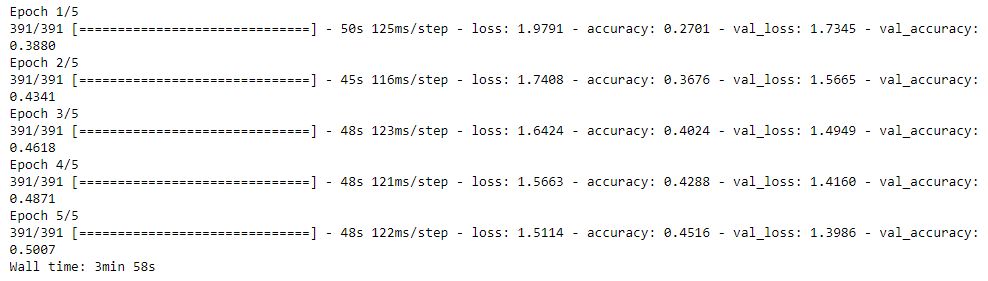
***
Время обучения свёрточной нейросети, рассмотренной на уроке - около 4 минут.
***


***
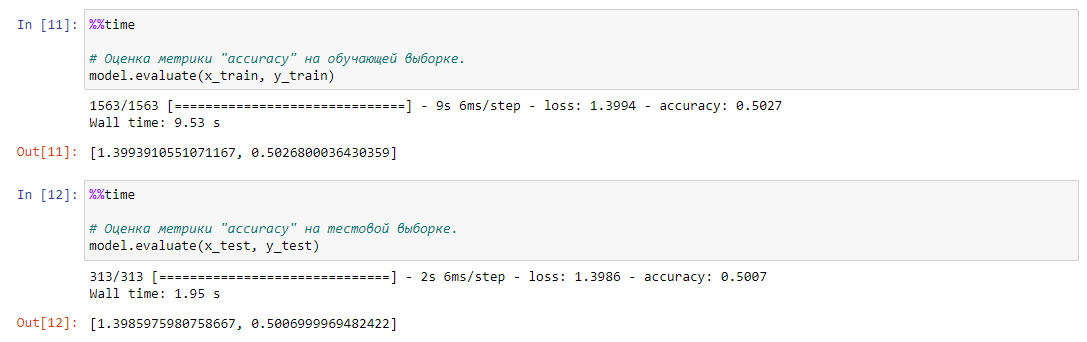
***
Метрика <code>accuracy</code> около 0.5 на обеих выборках - модель практически не переобучается.
***

#### Импорт библиотек

In [1]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import AveragePooling2D

import os
import matplotlib.pyplot as plt

#### Глобальные настройки проекта

In [2]:
# Случайное зерно.
GLOBAL__RANDOM_STATE = 0

# Веса моделей.
PATH__WEIGHTS_BASELINE = r'weights_baseline'
PATH__WEIGHTS_SECOND = r'weights_second'

# Установка параметров нейросети.
batch_size = 128
num_classes = 10
epochs = 5
data_augmentation = True
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_cifar10_trained_model.h5'

#### Загрузка данных

In [3]:
# Разделение тренировочной и тестовой выборки.
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'тренировочные примеры')
print(x_test.shape[0], 'тестовые примеры')

# Преобразование матрицы чисел 0-9 в бинарную матрицу чисел 0-1.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

x_train shape: (50000, 32, 32, 3)
50000 тренировочные примеры
10000 тестовые примеры


In [4]:
datagen = ImageDataGenerator(width_shift_range=0.1,
                             height_shift_range=0.1,
                             horizontal_flip=0.5)

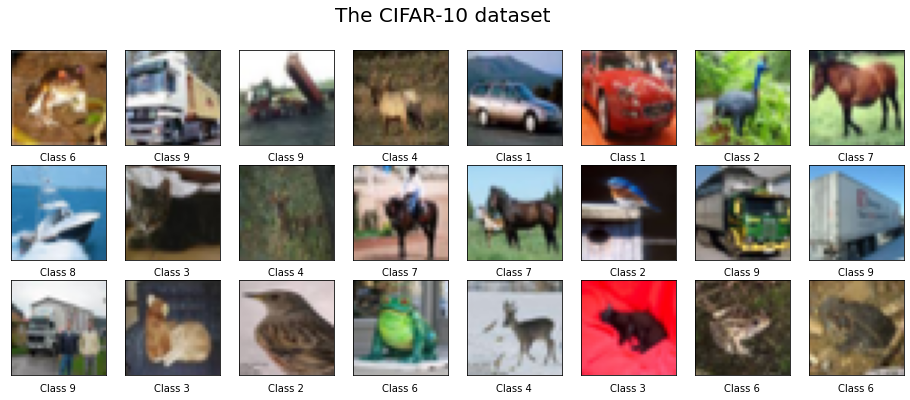

In [5]:
# Проверка: визуализация признаков.
fig, axes = plt.subplots(3, 8, figsize=(16, 6))
fig.suptitle('The CIFAR-10 dataset', fontsize=20)
n = 0
for ax in axes.flat:
    ax.set_yticks([])
    ax.set_xticks([])
    ax.imshow(x_train[n])
    ax.set_xlabel(f'Class {np.where(y_train[n] == 1)[0][0]}')
    n += 1

#### Модель из урока

In [15]:
# Конфигурирование слоев нейросети.
model_original = Sequential()

# Слои нейросети отвественные за свертку и max-pooling.
model_original.add(Conv2D(32, (3, 3), padding='same', input_shape=x_train.shape[1:]))
model_original.add(Activation('relu'))
model_original.add(Conv2D(32, (3, 3)))
model_original.add(Activation('relu'))
model_original.add(MaxPooling2D(pool_size=(2, 2)))
model_original.add(Dropout(0.25))

model_original.add(Conv2D(64, (3, 3), padding='same'))
model_original.add(Activation('relu'))
model_original.add(Conv2D(64, (3, 3)))
model_original.add(Activation('relu'))
model_original.add(MaxPooling2D(pool_size=(2, 2)))
model_original.add(Dropout(0.25))

# Полносвязные слои нейронной сети.
model_original.add(Flatten())
model_original.add(Dense(512))
model_original.add(Activation('relu'))
model_original.add(Dropout(0.5))
model_original.add(Dense(num_classes))
model_original.add(Activation('softmax'))

model_original.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 activation_2 (Activation)   (None, 32, 32, 32)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 30, 30, 32)        9248      
                                                                 
 activation_3 (Activation)   (None, 30, 30, 32)        0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 15, 15, 32)        0         
                                                      

In [7]:
x_train.shape[1:]

(32, 32, 3)

#### Модель, построенная по принципу алгоритма "YOLO"

In [8]:
# Конфигурирование слоев нейросети.
model = Sequential()

# Слои нейросети отвественные за свертку и max-pooling.
model.add(Conv2D(64, (4, 4), strides=(2, 2), padding='same', input_shape=x_train.shape[1:]))
model.add(MaxPooling2D(pool_size=(4, 4), strides=(1, 1), padding='same'))

model.add(Conv2D(128, (4, 4), strides=(2, 2), padding='same'))
model.add(MaxPooling2D(pool_size=(4, 4), strides=(1, 1), padding='same'))

# Полносвязные слои нейронной сети.
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 64)        3136      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         131200    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 128)        0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 512)               4

In [9]:
# Инициализация RMSprop optimizer.
opt = keras.optimizers.RMSprop(learning_rate=0.0001, decay=1e-6)

# Компиляция модели.
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [10]:
%%time

# Запуск data augmentation через fit_generator.
model.fit(datagen.flow(x_train,
                       y_train,
                       batch_size=batch_size),
          epochs=epochs,
          validation_data=(x_test, y_test),
          workers=4)

# Загрузка весов обученной модели.
# model.load_weights(PATH__WEIGHTS_BASELINE)

Epoch 1/5
391/391 [==============================] - 30s 76ms/step - loss: 1.7306 - accuracy: 0.3777 - val_loss: 1.4253 - val_accuracy: 0.4967
Epoch 2/5
391/391 [==============================] - 30s 76ms/step - loss: 1.4632 - accuracy: 0.4789 - val_loss: 1.3334 - val_accuracy: 0.5254
Epoch 3/5
391/391 [==============================] - 30s 76ms/step - loss: 1.3312 - accuracy: 0.5305 - val_loss: 1.1850 - val_accuracy: 0.5812
Epoch 4/5
391/391 [==============================] - 30s 76ms/step - loss: 1.2376 - accuracy: 0.5649 - val_loss: 1.1097 - val_accuracy: 0.6102
Epoch 5/5
391/391 [==============================] - 30s 76ms/step - loss: 1.1692 - accuracy: 0.5911 - val_loss: 1.0211 - val_accuracy: 0.6428
Wall time: 2min 29s


In [11]:
%%time

# Оценка метрики "accuracy" на обучающей выборке.
model.evaluate(x_train, y_train)

1563/1563 [==============================] - 8s 5ms/step - loss: 1.0046 - accuracy: 0.6513
Wall time: 7.84 s


[1.0045621395111084, 0.6512799859046936]

In [12]:
%%time

# Оценка метрики "accuracy" на тестовой выборке.
model.evaluate(x_test, y_test)

313/313 [==============================] - 2s 5ms/step - loss: 1.0211 - accuracy: 0.6428
Wall time: 1.64 s


[1.0210974216461182, 0.642799973487854]

In [14]:
# Сохранение весов лучшей модели с метрикой "accuracy": 0.6428.
# model.save_weights(PATH__WEIGHTS_BASELINE)

#### Выводы

Применение методов обработки изображений ***YOLO*** для классификации объектов показало следующие отличия от свёрточной сети, рассмотренной на уроке:

1. Время построения модели снизилось с 4 минут до 2.5, то есть уменьшилось более чем на треть в сравнении с классической свёрточной сетью.


2. Время прогноза на тестовой выборке снизилось с 1.95 секунд до 1.64, прирост составил около 15%.


3. Метрика <code>accuracy</code> выросла с 0.5 до 0.64.


4. Также стоит отметить, что построенная нейросеть практически не переобучается. Разница метрик <code>accuracy</code> на обучающей и тестовой выборках составляет менее сотой доли: 0.6513 - 0.6428 = 0.0085.


5. С сравнении с оригинальной моделью, построенная модель имеет более чем на треть меньше слоёв. 10 слоёв против 18 у модифицированной модели и оригинальной соответственно. При этом количество обучаемых параметров увеличилось почти в четыре раза, с 1,250,858 до 4,334,282. Из-за более оптимальной архитектуры они подбираются быстрее.

Данные показатели точности и быстродействия построенной модели доказываются эффективность алгоритма ***YOLO***, в частности его модификации ***Nano-YOLO***. Также стоит отметить, что подход разбиения входного изображения и сетку ячеек также применим не только в задачах детекции, но и классификации, так как последняя является подзадачей первой. Ключевой особенностью алгоритма является абстрагирование от всех комбинаций признаков и фокусирование внимания модели на выделенных ячейках и поиск наиболее важных из них.